# Example Instrumental Variable Modelling (IV) with `pymc` models

This notebook shows an example of using instrumental variable regression. We will follow an example from Acemoglu, Johnson and Robinson (2001) which attempted to disentangle the effect of robust political institutions on economic productivity measured in GDP terms. This notebook example draws on the discussion in {cite:t}`hansenEconometrics`

In [60]:
import arviz as az
from sklearn.linear_model import LinearRegression as sk_lin_reg

import causalpy as cp
from causalpy.pymc_experiments import ExperimentalDesign, InstrumentalVariable
from causalpy.pymc_models import (
    InstrumentalVariableRegression,
    LinearRegression,
    ModelBuilder,
)

In [112]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The idea of this work was to look at the different outcomes in `loggdp` terms for various colonised countries as a function of a measure of the robustness of political institutions `risk`. This latter variable is a score for the legal protection available against expropriation of property. The higher the score, the more legal protection available. The thought is that legal and political institutional structures have long-lasting benefits and since the colonies were treated differently under different colonial powers (with varying degree of institutional development), the argument is that we can potentially estimate the effects of political institution on GDP with this kind of data. 

In a picture:

![IV Regression](../_static/iv_reg.png)

Here the $X$ covariates contain a treatment variable (`risk`) which is correlated with the outcome $Y$ (`loggdp`) through the intermediating values of $H$ (unmeasured history) violating the OLS assumptions of independence. The idea is to recover the unbiased treatment effect of risk by invoking $Z$ our instrument(s) `logmort0` which is assumed to be correlated with $Y$ only through its influence on $X$. 

This relatively simple graph occurs quite commonly in the context of policy adoption, where we're interested in the effect of some treatment/policy $X_{t}$ on a population, where $Z$ is some measure that influences adoption. As such instrumental variable regression are often quite useful in industry.

In [175]:
iv_df = cp.load_data("risk")
iv_df[["loggdp", "risk", "logmort0"]]

,loggdp,risk,logmort0
0,7.77,5.36,5.634790
1,9.13,6.39,4.232656
2,9.90,9.32,2.145931
3,6.85,4.45,5.634790
4,6.88,5.14,4.268438
...,...,...,...
59,10.22,10.00,2.708050
60,9.07,7.14,4.357990
61,7.28,6.41,4.941642
62,8.89,6.86,2.740840


The complication emerges when we observe that political institutions are **engodgenous** in the system which lead to that growth. So we need to control in some way for measurement error and bias we could expect if we fit a simple OLS model. They continue to argue that we can use an instrumental variable which is correlated with GDP only through the degree of political institutions by using instrumental variable regression. They suggesting using mortality rates faced by European settlers in the period as an instrument, because higher mortality rates will lead to less migration and investment in the error which should see a reduction in the political institutions established in the colonies. They could gather this data using military records. 

We can manually estimate the 2SLS (Two stage least squares) estimate for the treatment effect of `risk` as follows: 

In [176]:
X = iv_df.risk.values.reshape(-1, 1)
Z = iv_df.logmort0.values.reshape(-1, 1)
t = iv_df.risk.values
y = iv_df.loggdp.values

simple_ols_reg = sk_lin_reg().fit(X, y)
first_stage_reg = sk_lin_reg().fit(Z, t)
fitted_risk_values = first_stage_reg.predict(Z)


second_stage_reg = sk_lin_reg().fit(X=fitted_risk_values.reshape(-1, 1), y=y)

print(
    "Simple OLS Parameters: Intercept and Beta Coeff",
    simple_ols_reg.intercept_,
    simple_ols_reg.coef_,
)
print(
    "First Stage Parameters: Intercept and Beta Coeff",
    first_stage_reg.intercept_,
    first_stage_reg.coef_,
)
print(
    "Second Stage Parameters Intercept and Beta Coeff",
    second_stage_reg.intercept_,
    second_stage_reg.coef_,
)

Simple OLS Parameters: Intercept and Beta Coeff 4.687414702305412 [0.51618698]
First Stage Parameters: Intercept and Beta Coeff 9.365894904697788 [-0.61328925]
Second Stage Parameters Intercept and Beta Coeff 1.9942956864448975 [0.92948966]


Note the significant differences between the naive OLS estimate `0.515` and the 2SLS estimate of `0.92`. This accords with the results reported in the paper. 

In this notebook we will not further discuss the issues around weak and strong instrumental variables, how to find and test the strength of instruments, but we will demonstrate how to fit these types of models in the Bayesian setting. We will also discuss how the Bayesian approach under hood models both the focal (second stage) and the instrumental (first stage) regression as a multivariate random variable with explicit correlations.

\begin{align*}
\left(
\begin{array}{cc}
y \\
t
\end{array}
\right)
& \sim
\text{MultiNormal}(\mu, \Sigma) \\
\mu & = \left(
\begin{array}{cc}
\mu_{y} \\
\mu_{t}
\end{array}
\right)
=
\left(
\begin{array}{cc}
\beta_{t}t + a_{y} \\
\beta_{z}z + a_{t}
\end{array}
\right)
\end{align*}


In this we follow the example of Juan Orduz's [blog](https://juanitorduz.github.io/iv_pymc/) which in turn draws upon Jim Savage's [work](https://khakieconomics.github.io/2017/11/26/Bayesian_iv.html)

In [113]:
sample_kwargs = {"tune": 1000, "draws": 2000, "chains": 2, "cores": 1}
instruments_formula = "risk  ~ 1 + logmort0"
formula = "loggdp ~  1 + risk"
instruments_data = iv_df[["risk", "logmort0"]]
data = iv_df[["loggdp", "risk"]]
# priors = {"mus": [[10, 0], [2, 0]], "sigmas": [[1, 1], [1, 1]]}
iv = InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
)


iv.model.idata

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

The parameters of primary interest are the beta parameters on the `risk` variable here, which agrees quite closely with the MLE fits we saw earlier using two stage least squares. 

In [114]:
az.summary(iv.model.idata, var_names=["beta_t", "beta_z"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_t[Intercept],9.451,0.463,8.627,10.334,0.013,0.009,1285.0,2077.0,1.00
beta_t[logmort0],-0.631,0.095,-0.816,-0.463,0.003,0.002,1211.0,2016.0,1.00
beta_z[Intercept],2.234,0.674,0.973,3.471,0.026,0.018,716.0,1069.0,1.01
beta_z[risk],0.892,0.103,0.702,1.083,0.004,0.003,711.0,1077.0,1.01


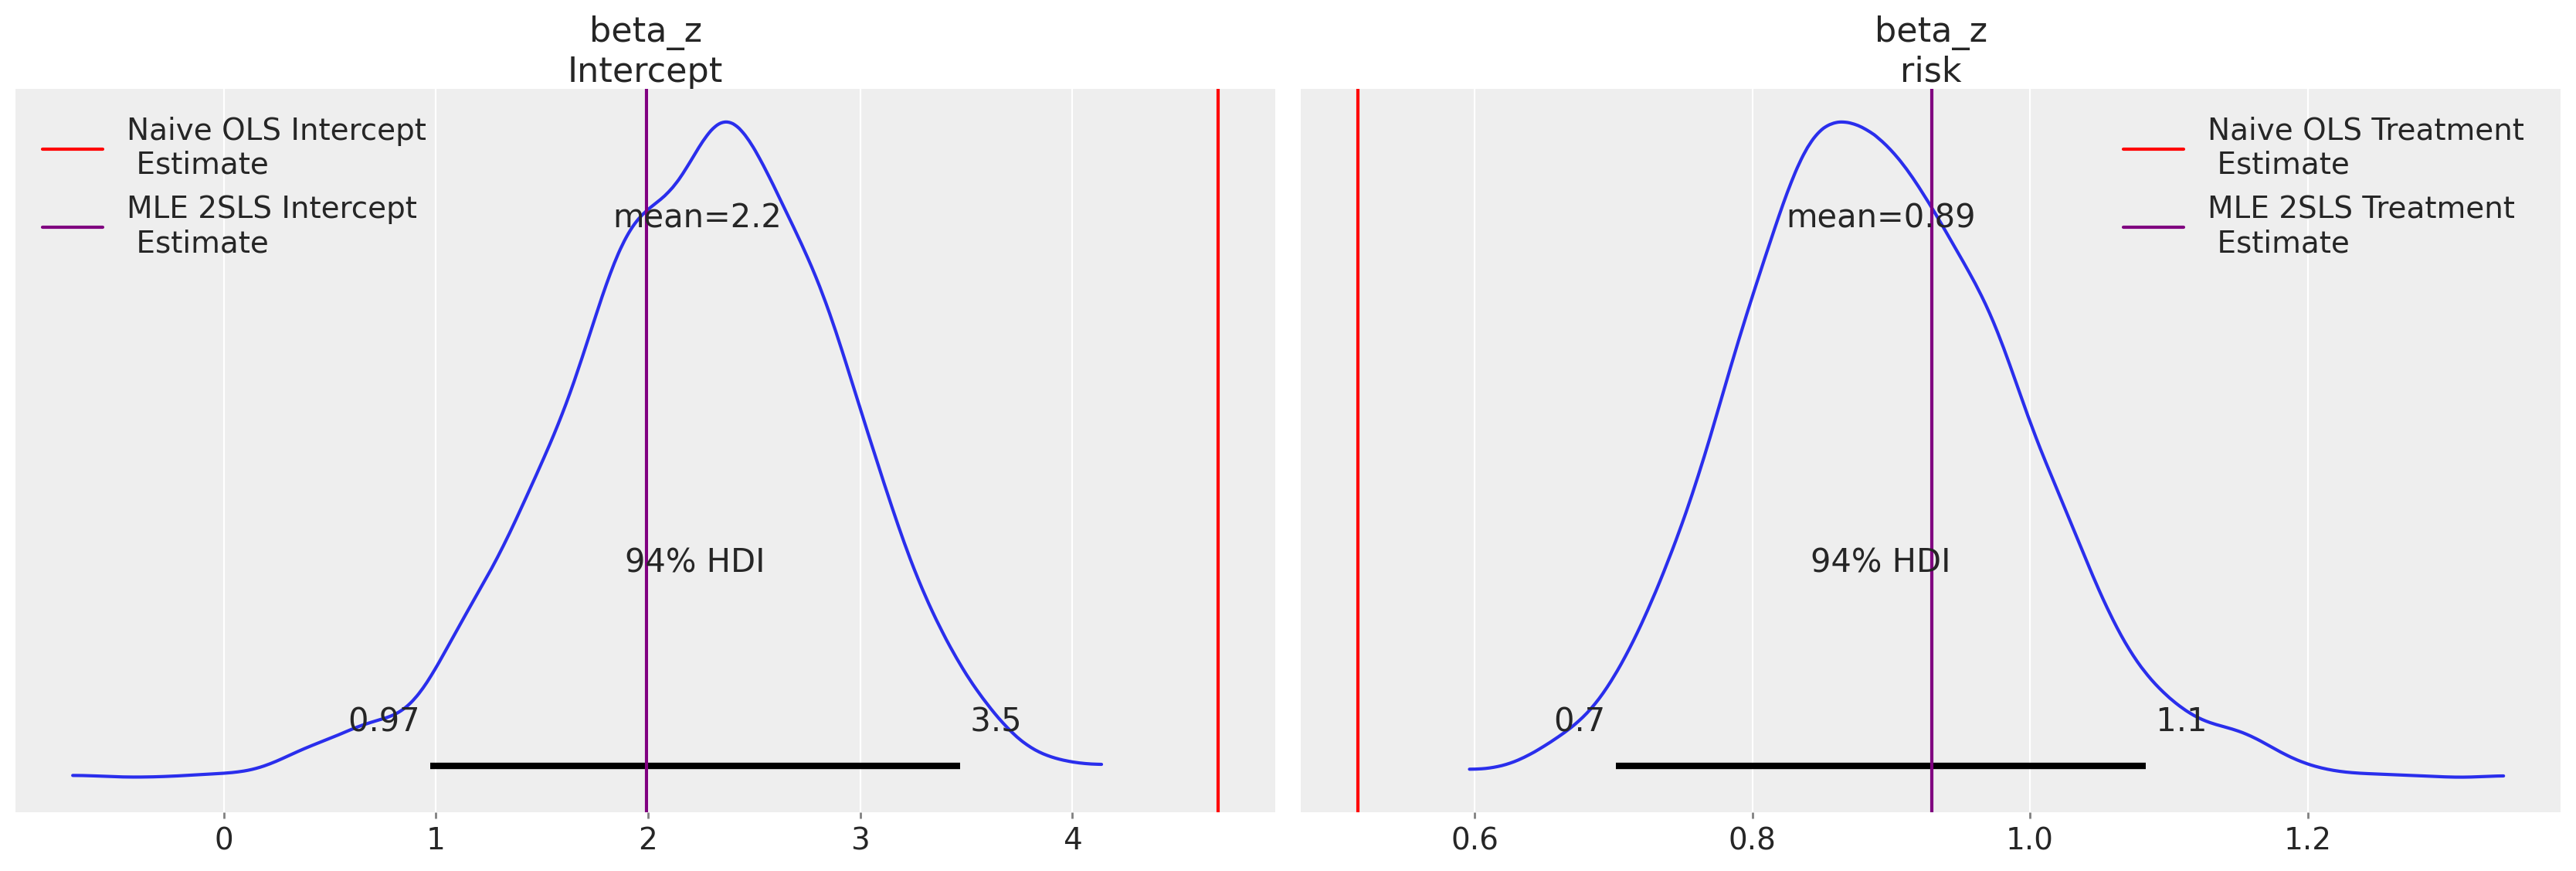

In [163]:
hdi_prob = 0.94
ax = az.plot_posterior(
    data=iv.model.idata,
    var_names=["beta_z"],
    hdi_prob=hdi_prob,
)

ax[0].axvline(
    iv.ols_beta_params["Intercept"],
    label="Naive OLS Intercept \n Estimate",
    color="red",
)
ax[1].axvline(
    iv.ols_beta_params[iv.instrument_variable_name],
    label="Naive OLS Treatment \n Estimate",
    color="red",
)
ax[0].axvline(
    iv.ols_beta_second_params[0], label="MLE 2SLS Intercept \n Estimate", color="purple"
)
ax[1].axvline(
    iv.ols_beta_second_params[1], label="MLE 2SLS Treatment \n Estimate", color="purple"
)
ax[0].legend()
ax[1].legend();

### Multivariate Outcomes and Measures of Correlation

We can see (in two dimensions) a representation of how the difference in the estimated treatment coefficients skews the expected outcomes. 

In [189]:
az.summary(iv.model.idata, var_names=["chol_cov_corr"])

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"chol_cov_corr[0, 0]",1.000,0.000,1.000,1.0,0.000,0.000,4000.0,4000.0,NaN
"chol_cov_corr[0, 1]",-0.692,0.097,-0.854,-0.5,0.003,0.002,858.0,1195.0,1.0
"chol_cov_corr[1, 0]",-0.692,0.097,-0.854,-0.5,0.003,0.002,858.0,1195.0,1.0
"chol_cov_corr[1, 1]",1.000,0.000,1.000,1.0,0.000,0.000,4076.0,3771.0,1.0


Text(0.5, 1.0, 'Correlation between \n Outcome and Treatment')

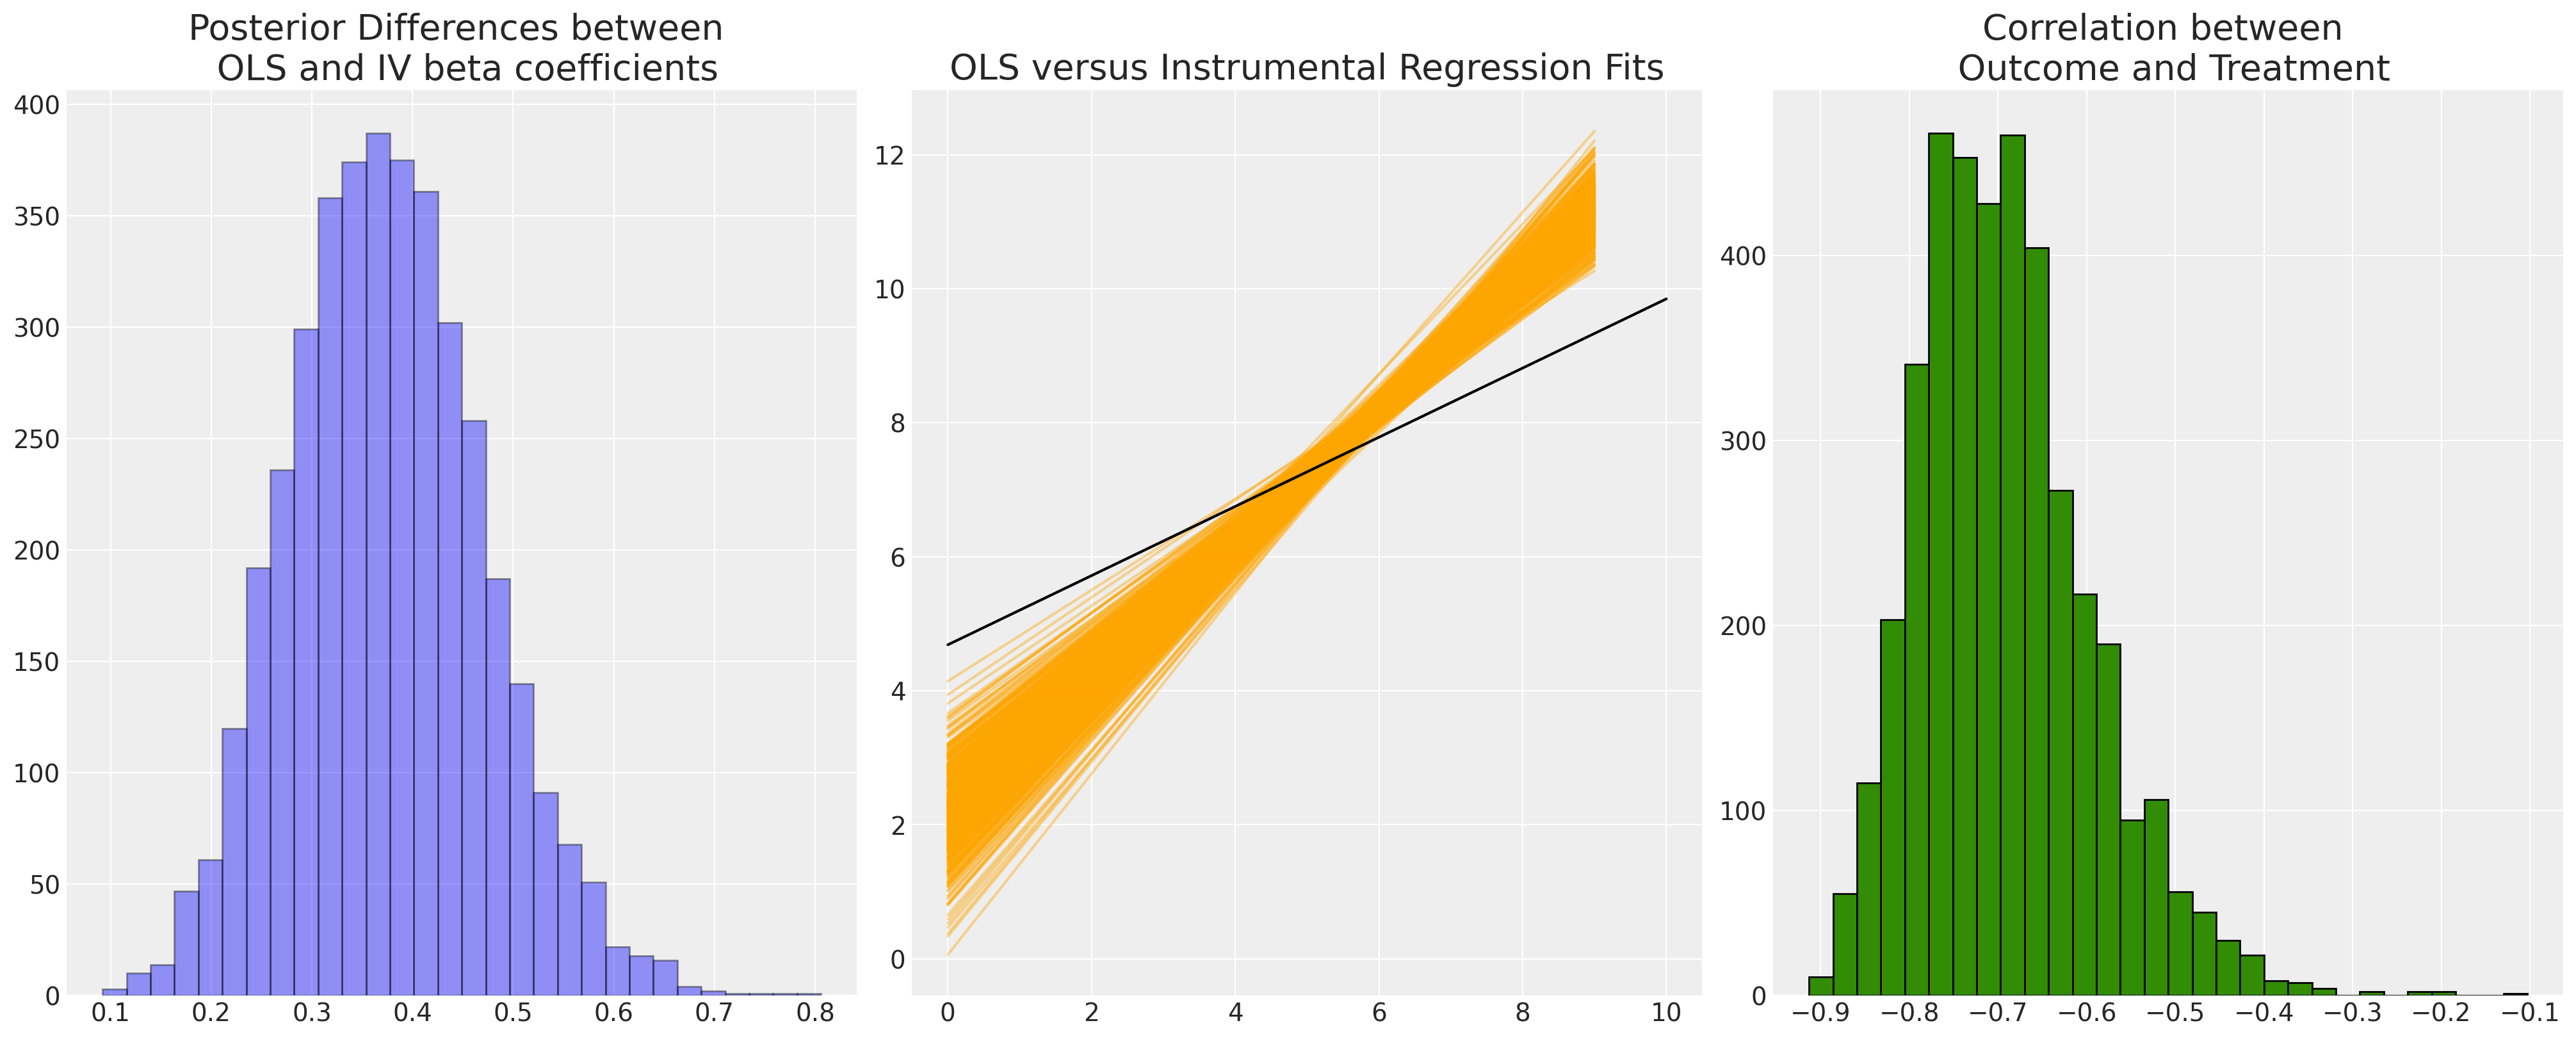

In [194]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

diffs = (
    idata["posterior"]["beta_z"].sel(covariates=[iv.instrument_variable_name])
    - iv.ols_beta_params[iv.instrument_variable_name]
)
axs[0].hist(diffs.values.flatten(), bins=30, ec="black", color="blue", alpha=0.4)

intercepts = idata["posterior"]["beta_z"].sel(covariates=["Intercept"])
betas = idata["posterior"]["beta_z"].sel(covariates=[iv.instrument_variable_name])


raw_df = pd.DataFrame(iv.X, columns=iv.labels)
x = np.linspace(0, 10, 10)
uncertainty = [intercepts.values.flatten() + betas.values.flatten() * i for i in x]
uncertainty = pd.DataFrame(uncertainty).T

ols = [
    iv.ols_beta_params["Intercept"]
    + iv.ols_beta_params[iv.instrument_variable_name] * i
    for i in x
]
uncertainty.sample(500).T.plot(legend=False, color="orange", alpha=0.4, ax=axs[1])
axs[1].plot(x, ols, color="black", label="OLS fit")
axs[1].set_title("OLS versus Instrumental Regression Fits", fontsize=20)
axs[0].set_title(
    "Posterior Differences between \n OLS and IV beta coefficients", fontsize=20
)

corr = az.extract(data=iv.model.idata, var_names=["chol_cov_corr"])[0, 1, :]
axs[2].hist(corr, bins=30, ec="black", color="C2", label="correlation")
axs[2].set_title("Correlation between \n Outcome and Treatment", fontsize=20)

## References
:::{bibliography}
:filter: docname in docnames
:::